# PGA: Capstone Project - The Battle of Neighborhoods (Week 1)
## Data retrieval and exploration

**Importing the libraries for our tasks.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim

import folium

import json
import requests
from pandas.io.json import json_normalize

### First data source: Scraping German cities wikipedia table

In [2]:
url='https://de.wikipedia.org/wiki/Liste_der_Gro%C3%9Fst%C3%A4dte_in_Deutschland'

dfs = pd.read_html(url, attrs={'class': 'wikitable sortable zebra mw-datatable'}, thousands=".")

cities = dfs[0].droplevel(level=0, axis=1)
cities.drop(cities.tail(2).index, inplace=True)

cities = cities[['Name', '2018', 'Fläche in km² (2016)', 'Bun­des­land']]
cities.rename(columns={"Name": "City", "2018": "Population", "Fläche in km² (2016)": "Area", "Bun­des­land": "State"}, inplace=True)

print(cities.shape)
print(cities.dtypes)
cities.head()

(80, 4)
City          object
Population    object
Area          object
State         object
dtype: object


,City,Population,Area,State
0,Berlin1,3644826,"891,68",Berlin
1,Hamburg1,1841179,"755,22",Hamburg
2,München,1471508,"310,70",Bayern
3,Köln1,1085664,"405,02",Nordrhein-Westfalen
4,Frankfurt am Main,753056,"248,31",Hessen


In [3]:
cities.columns

Index(['City', 'Population', 'Area', 'State'], dtype='object')

**Conversion of datatypes, replacement of umlauts, deletion of remark numbers.**

In [4]:
cities = cities.convert_dtypes()

cities['Population'] = cities['Population'].astype('int')
cities['Area'] = cities['Area'].str.replace(',','.').astype('float')

cities['City'] = cities['City'].str.replace('ü', 'ue')
cities['City'] = cities['City'].str.replace('ä', 'ae')
cities['City'] = cities['City'].str.replace('ö', 'oe')
cities['City'] = cities['City'].str.replace('ß', 'ss')
cities['City'] = cities['City'].str.replace('[^a-zA-Z ]', '')

cities['State'] = cities['State'].str.replace('ü', 'ue')
cities['State'] = cities['State'].str.replace('ä', 'ae')
cities['State'] = cities['State'].str.replace('ö', 'oe')
cities['State'] = cities['State'].str.replace('ß', 'ss')

print(cities.dtypes)
print(cities.shape)
cities

City           string
Population      int64
Area          float64
State          string
dtype: object
(80, 4)


,City,Population,Area,State
0,Berlin,3644826,891.68,Berlin
1,Hamburg,1841179,755.22,Hamburg
2,Muenchen,1471508,310.70,Bayern
3,Koeln,1085664,405.02,Nordrhein-Westfalen
4,Frankfurt am Main,753056,248.31,Hessen
...,...,...,...,...
75,Salzgitter,104948,223.92,Niedersachsen
76,Moers,103725,67.68,Nordrhein-Westfalen
77,Siegen,102836,114.69,Nordrhein-Westfalen
78,Hildesheim,101990,92.18,Niedersachsen


**Adding some more information for later on: the age statistics table for the German states. It will be merged with the dataframe in the next step.**

In [5]:
url='https://www.statistikportal.de/en/node/132'

dfs = pd.read_html(url, thousands=".")

age = dfs[1]                           

# reducing the levels
age = age.droplevel(level=0, axis=1)
age = age.droplevel(level=0, axis=1)
age = age.droplevel(level=1, axis=1)

# dropping summarizing row
# age.drop(columns=['unter 3', '3 – 6', '6 – 15', '75 und mehr'], inplace=True)
age.drop([16], inplace=True)

# renaming and replacing umlauts
age.rename(columns={"Bundesland": "State"}, inplace=True)
age['State'] = age['State'].str.replace('ü', 'ue')
age['State'] = age['State'].str.replace('ä', 'ae')
age['State'] = age['State'].str.replace('ö', 'oe')
age['State'] = age['State'].str.replace('ß', 'ss')

age = age.convert_dtypes()

for col in range(1, age.shape[1]):
    age[age.columns[col]] = age[age.columns[col]].str.replace(',','.').astype('float')

print(age.shape)
print(age.dtypes)
age.head()

(16, 12)
State           string
unter 3        float64
3 – 6          float64
6 – 15         float64
15 – 18        float64
18 – 25        float64
25 – 30        float64
30 – 40        float64
40 – 50        float64
50 – 65        float64
65 – 75        float64
75 und mehr    float64
dtype: object


,State,unter 3,3 – 6,6 – 15,15 – 18,18 – 25,25 – 30,30 – 40,40 – 50,50 – 65,65 – 75,75 und mehr
0,Baden-Wuerttemberg,2.6,2.7,9.2,3.3,8.7,6.1,12.0,16.6,19.6,10.5,8.9
1,Bayern,2.5,2.6,8.8,3.2,8.4,6.1,12.3,16.8,19.8,10.7,8.8
2,Berlin,2.9,2.6,7.2,2.3,8.3,7.9,14.1,16.4,19.0,11.4,7.8
3,Brandenburg,2.3,2.3,7.1,1.9,7.1,5.5,10.8,17.3,22.9,13.0,9.7
4,Bremen,2.4,2.4,7.7,2.7,9.1,7.1,12.3,15.6,19.5,11.6,9.6


Summarizing the age group percentages from 15-40 as "young" and from 40-75 as "old" and calculating the difference between them.

In [6]:
age['Population Share Age <40'] = (age['unter 3'] + age['3 – 6'] + age['6 – 15'] + age['15 – 18'] + age['18 – 25'] + age['25 – 30'] + age['30 – 40'])
#age['Population Share Age >40'] = (age['40 – 50'] + age['50 – 65'] + age['65 – 75'] + age['75 und mehr'])

age = age[['State', 'Population Share Age <40']]
    
print(age.dtypes)
print(age.shape)
age.head()

State                        string
Population Share Age <40    float64
dtype: object
(16, 2)


,State,Population Share Age <40
0,Baden-Wuerttemberg,44.6
1,Bayern,43.9
2,Berlin,45.3
3,Brandenburg,37.0
4,Bremen,43.7


In [7]:
cities_age = pd.merge(cities,
                      age,
                      on='State',
                      how='right')
print(cities_age.shape)
cities_age.head()

(80, 5)


,City,Population,Area,State,Population Share Age <40
0,Berlin,3644826,891.68,Berlin,45.3
1,Hamburg,1841179,755.22,Hamburg,47.1
2,Muenchen,1471508,310.70,Bayern,43.9
3,Nuernberg,518365,186.38,Bayern,43.9
4,Augsburg,295135,146.84,Bayern,43.9


**Histogram plot by population.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bb2e70dd0>]],
      dtype=object)

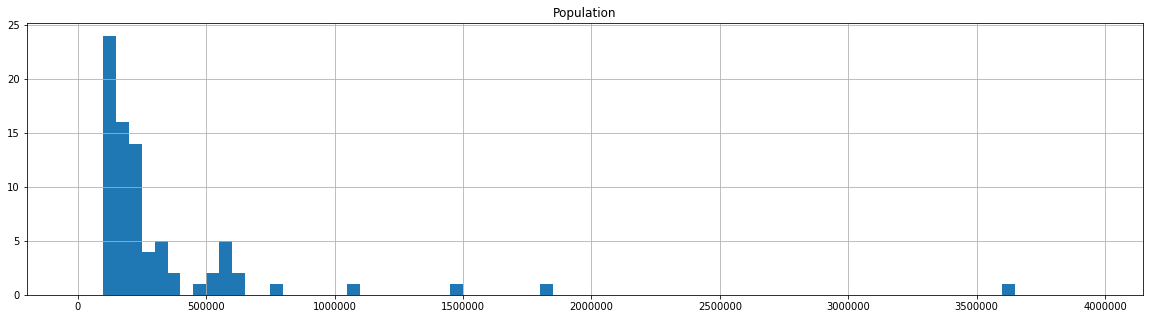

In [8]:
cities_age.hist(column='Population', bins=np.arange(0,4000000,50000), figsize=(20, 5))

**Statistical summary**

In [9]:
cities_age.describe().round(3)

,Population,Area,Population Share Age <40
count,80.000,80.000,80.000
mean,331745.075,172.148,42.426
std,472124.614,129.270,1.991
min,100194.000,44.890,36.700
25%,127393.250,99.140,42.100
50%,195199.500,139.415,42.700
75%,313398.750,204.942,43.700
max,3644826.000,891.680,47.100


Half of the cities have a population of less than 188,814 and area of less than 141.06 sqkm.

**Adding geolocation**

In [10]:
lat_list=[]
lng_list=[]

for row in range(cities_age.shape[0]):
    geolocator = Nominatim(user_agent="coursera_capstone")
    location = geolocator.geocode('{}, Germany'.format(cities_age.iloc[row, 0]))
    try:
        lat_list.append(location.latitude)
        lng_list.append(location.longitude)
    except AttributeError:
        lat_list.append(np.nan)
        lng_list.append(np.nan)
        continue
    print(cities_age.iloc[row,0])

cities_age.insert(loc=3, column='Latitude', value=lat_list)
cities_age.insert(loc=4, column='Longitude', value=lng_list)

print(cities_age.shape)
print(cities_age.dtypes)
cities_age.head()

Berlin
Hamburg
Muenchen
Nuernberg
Augsburg
Regensburg
Ingolstadt
Wuerzburg
Fuerth
Erlangen
Koeln
Duesseldorf
Dortmund
Essen
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Muenster
Moenchengladbach 
Gelsenkirchen
Aachen
Krefeld
Oberhausen
Hagen
Hamm
Leverkusen
Solingen
Herne
Neuss
Paderborn
Bottrop
Recklinghausen
Bergisch Gladbach
Remscheid
Moers
Siegen
Guetersloh
Frankfurt am Main
Wiesbaden
Kassel
Darmstadt
Offenbach am Main
Stuttgart
Karlsruhe
Mannheim
Freiburg im Breisgau
Heidelberg
Ulm
Heilbronn
Pforzheim
Reutlingen
Leipzig
Dresden
Chemnitz
Bremen
Bremerhaven 
Hannover
Braunschweig
Oldenburg Oldb
Osnabrueck
Wolfsburg
Goettingen
Salzgitter 
Hildesheim
Kiel
Luebeck
Halle Saale
Magdeburg
Mainz
Ludwigshafen am Rhein
Koblenz
Trier
Erfurt
Jena
Rostock
Saarbruecken
Potsdam
(80, 7)
City                         string
Population                    int64
Area                        float64
Latitude                    float64
Longitude                   float64
State                        string
Po

,City,Population,Area,Latitude,Longitude,State,Population Share Age <40
0,Berlin,3644826,891.68,52.517037,13.388860,Berlin,45.3
1,Hamburg,1841179,755.22,53.543764,10.009913,Hamburg,47.1
2,Muenchen,1471508,310.70,48.137108,11.575382,Bayern,43.9
3,Nuernberg,518365,186.38,49.453872,11.077298,Bayern,43.9
4,Augsburg,295135,146.84,48.366804,10.898697,Bayern,43.9


In [11]:
# Show errors and drop the rows
print(cities_age.loc[cities_age['Latitude'].isna()])
cities_age.drop(cities_age[cities_age['Latitude'].isna()].index, axis=0, inplace=True)
print(cities_age.loc[cities_age['Latitude'].isna()])

                   City  Population   Area  Latitude  Longitude  \
27  Muelheim an derRuhr      170880  91.28       NaN        NaN   

                  State  Population Share Age <40  
27  Nordrhein-Westfalen                      42.7  
Empty DataFrame
Columns: [City, Population, Area, Latitude, Longitude, State, Population Share Age <40]
Index: []


**Mapping the locations of the cities**

In [12]:
# creating the map
map_cities = folium.Map(location=[51.351, 10.454], zoom_start=5.5)

# add markers of citis to map
for lat, lng, city, pop in zip(cities_age['Latitude'], cities_age['Longitude'], cities_age['City'], cities_age['Population']):
    label = '{} (Population: {})'.format(city, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cities)

map_cities

### Second data source: Retrieving the venues for the cities from Foursquare.

In [13]:
CLIENT_ID = 'AOUOE4WYOQXAMZABF1J3HUQCXZ0GBEETIUCZDQOUYR0JGRQD' # your Foursquare ID
CLIENT_SECRET = 'MCY5M5APBTGR1J2QR20PQLZ2YVJBXRBG4OOML1ZHAMLHYCGR' # your Foursquare Secret
VERSION = '20200522' # Foursquare API version
LIMIT = 1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AOUOE4WYOQXAMZABF1J3HUQCXZ0GBEETIUCZDQOUYR0JGRQD
CLIENT_SECRET:MCY5M5APBTGR1J2QR20PQLZ2YVJBXRBG4OOML1ZHAMLHYCGR


In [14]:
def getNearbyVenues(cities, latitudes, longitudes, radius):
    
    venues_list=[]
    for city, lat, lng in zip(cities, latitudes, longitudes):
        print(city)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']
        except KeyError:
            continue
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

**Calculating the search radius using the median city size (area)**

In [15]:
radius = round(np.sqrt(cities_age['Area'].median()/np.pi)*1000)
radius

6701.0

In [16]:
cities_age_venues = getNearbyVenues(cities=cities_age['City'],
                                   latitudes=cities_age['Latitude'],
                                   longitudes=cities_age['Longitude'],
                                   radius=radius
                                  )

Berlin
Hamburg
Muenchen
Nuernberg
Augsburg
Regensburg
Ingolstadt
Wuerzburg
Fuerth
Erlangen
Koeln
Duesseldorf
Dortmund
Essen
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Muenster
Moenchengladbach 
Gelsenkirchen
Aachen
Krefeld
Oberhausen
Hagen
Hamm
Leverkusen
Solingen
Herne
Neuss
Paderborn
Bottrop
Recklinghausen
Bergisch Gladbach
Remscheid
Moers
Siegen
Guetersloh
Frankfurt am Main
Wiesbaden
Kassel
Darmstadt
Offenbach am Main
Stuttgart
Karlsruhe
Mannheim
Freiburg im Breisgau
Heidelberg
Ulm
Heilbronn
Pforzheim
Reutlingen
Leipzig
Dresden
Chemnitz
Bremen
Bremerhaven 
Hannover
Braunschweig
Oldenburg Oldb
Osnabrueck
Wolfsburg
Goettingen
Salzgitter 
Hildesheim
Kiel
Luebeck
Halle Saale
Magdeburg
Mainz
Ludwigshafen am Rhein
Koblenz
Trier
Erfurt
Jena
Rostock
Saarbruecken
Potsdam


In [17]:
print(cities_age_venues.dtypes)
cities_age_venues.head()

City               object
City Latitude     float64
City Longitude    float64
Venue              object
Venue Category     object
dtype: object


,City,City Latitude,City Longitude,Venue,Venue Category
0,Berlin,52.517037,13.38886,Dussmann das KulturKaufhaus,Bookstore
1,Berlin,52.517037,13.38886,Dussmann English Bookshop,Bookstore
2,Berlin,52.517037,13.38886,Konzerthaus Berlin,Concert Hall
3,Berlin,52.517037,13.38886,Lafayette Gourmet,Gourmet Shop
4,Berlin,52.517037,13.38886,Gendarmenmarkt,Plaza


**Creating the onehot encoded and the subsequentally grouped dataframe for use in the analysis part.**

In [37]:
# onehot
cities_age_venues_onehot = pd.get_dummies(cities_age_venues[['Venue Category']], prefix="", prefix_sep="")
cities_age_venues_onehot['City'] = cities_age_venues['City'] 
fixed_columns = [cities_age_venues_onehot.columns[-1]] + list(cities_age_venues_onehot.columns[:-1])
cities_age_venues_onehot = cities_age_venues_onehot[fixed_columns]

# grouped by city
cities_age_venues_grouped = cities_age_venues_onehot.groupby('City').mean().reset_index()
cities_age_venues_grouped.head()

,City,Advertising Agency,African Restaurant,Airport,American Restaurant,Amphitheater,Apple Wine Pub,Aquarium,Arcade,Argentinian Restaurant,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Aachen,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.01,0.0,0.0,0.0,0.010000,0.000000
1,Augsburg,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.010000,0.000000
2,Bergisch Gladbach,0.0,0.0,0.0,0.027027,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.013514
3,Berlin,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.01,0.02,0.0,0.03,0.0,0.0,0.0,0.000000,0.000000
4,Bielefeld,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,...,0.010989,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.010989,0.000000


**Selecting the top 5 venues per city and adding them to the dataframe.**

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_age_venues_grouped_top = pd.DataFrame(columns=columns)
cities_age_venues_grouped_top['City'] = cities_age_venues_grouped['City']

for ind in np.arange(cities_age_venues_grouped.shape[0]):
    cities_age_venues_grouped_top.iloc[ind, 1:] = return_most_common_venues(cities_age_venues_grouped.iloc[ind, :], num_top_venues)

print(cities_age_venues_grouped_top.shape)
cities_age_venues_grouped_top.head()

(73, 6)


,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aachen,Supermarket,German Restaurant,Bar,Italian Restaurant,Plaza
1,Augsburg,Italian Restaurant,Steakhouse,Beer Garden,German Restaurant,Café
2,Bergisch Gladbach,Supermarket,Drugstore,Hotel,Italian Restaurant,Hardware Store
3,Berlin,Coffee Shop,Bookstore,Park,Ice Cream Shop,Monument / Landmark
4,Bielefeld,Supermarket,Hotel,Train Station,Bar,Bakery


Grouping the Foursquare dataframe by city to see how many venues were found per city.
Adding the number of venues and some additional metrics, venue count per population and venue count per area, to the grouped dataframe.

In [39]:
cities_age_venues_count = cities_age_venues.groupby(['City']).count()

cities_age_venues_count = cities_age_venues_count.drop(columns=['City Latitude', 'City Longitude', 'Venue Category']).rename(columns={"Venue": "Venues"})

cities_age_venues_count = pd.merge(cities_age,
                                   cities_age_venues_count,
                                   on='City',
                                   how='left')

cities_age_venues_count['Venues per Population'] = cities_age_venues_count.apply(lambda row: row.Venues/(row.Population/100000), axis = 1)
cities_age_venues_count = cities_age_venues_count.round({'Venues per Population': 6})

cities_age_venues_count['Venues per Area'] = cities_age_venues_count.apply(lambda row: row.Venues/row.Area, axis = 1)
cities_age_venues_count = cities_age_venues_count.round({'Venues per Area': 6})

print(cities_age_venues_count.dtypes)
cities_age_venues_count.head()

City                         object
Population                    int64
Area                        float64
Latitude                    float64
Longitude                   float64
State                        string
Population Share Age <40    float64
Venues                      float64
Venues per Population       float64
Venues per Area             float64
dtype: object


,City,Population,Area,Latitude,Longitude,State,Population Share Age <40,Venues,Venues per Population,Venues per Area
0,Berlin,3644826,891.68,52.517037,13.388860,Berlin,45.3,100.0,2.743615,0.112148
1,Hamburg,1841179,755.22,53.543764,10.009913,Hamburg,47.1,100.0,5.431302,0.132412
2,Muenchen,1471508,310.70,48.137108,11.575382,Bayern,43.9,100.0,6.795750,0.321854
3,Nuernberg,518365,186.38,49.453872,11.077298,Bayern,43.9,100.0,19.291426,0.536538
4,Augsburg,295135,146.84,48.366804,10.898697,Bayern,43.9,100.0,33.882799,0.681013


**Merging everything into one dataframe.**

In [41]:
cities_age_venues_grouped = pd.merge(cities_age_venues_count,
                                     cities_age_venues_grouped_top,
                                     on='City',
                                     how='left')
cities_age_venues_grouped.head()

,City,Population,Area,Latitude,Longitude,State,Population Share Age <40,Venues,Venues per Population,Venues per Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berlin,3644826,891.68,52.517037,13.388860,Berlin,45.3,100.0,2.743615,0.112148,Coffee Shop,Bookstore,Park,Ice Cream Shop,Monument / Landmark
1,Hamburg,1841179,755.22,53.543764,10.009913,Hamburg,47.1,100.0,5.431302,0.132412,Hotel,Café,Coffee Shop,Seafood Restaurant,Vietnamese Restaurant
2,Muenchen,1471508,310.70,48.137108,11.575382,Bayern,43.9,100.0,6.795750,0.321854,Café,Plaza,Hotel,Ice Cream Shop,German Restaurant
3,Nuernberg,518365,186.38,49.453872,11.077298,Bayern,43.9,100.0,19.291426,0.536538,Park,Café,Coffee Shop,Gym / Fitness Center,Bakery
4,Augsburg,295135,146.84,48.366804,10.898697,Bayern,43.9,100.0,33.882799,0.681013,Italian Restaurant,Steakhouse,Beer Garden,German Restaurant,Café


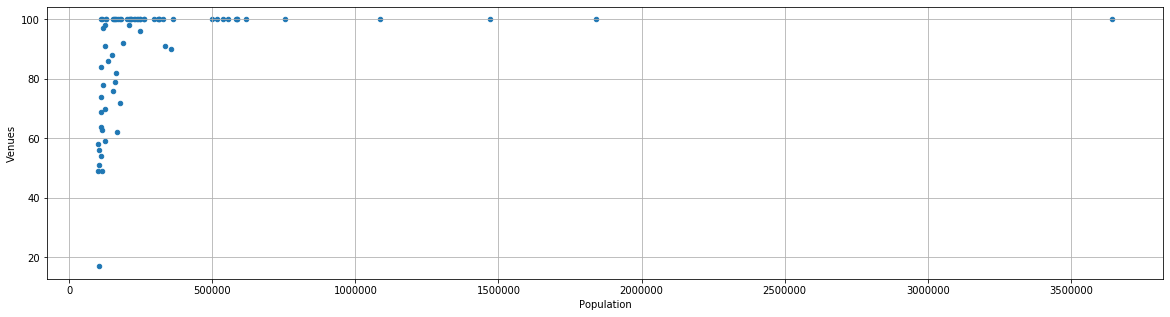

In [44]:
cities_age_venues_grouped.plot.scatter(x='Population', y='Venues', figsize=(20,5), grid=True)

Of course, bigger cities reach the maximum retrievable count of 100 venues easily.

But one can see, that there is quite a range in the venue count for the smaller cities.

To make this range more distinctable one can plot the population on a logarithmic axis.

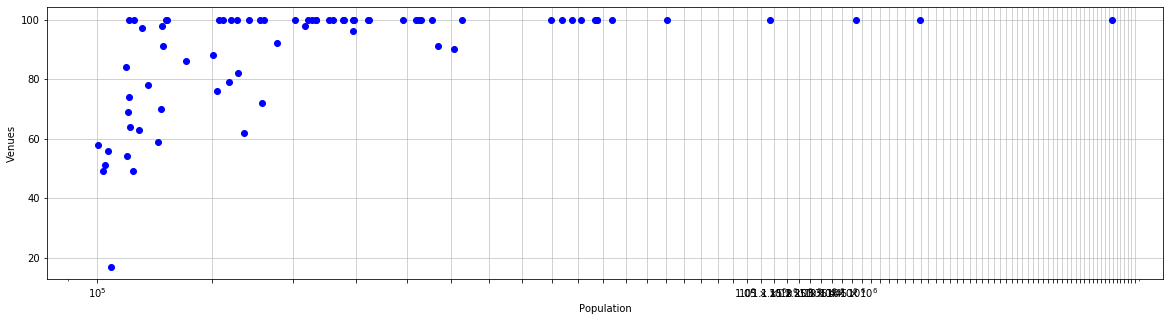

In [45]:
x_data = cities_age_venues_grouped['Population']
y_data = cities_age_venues_grouped['Venues']

fig = plt.figure(figsize=(20,5))
ax = plt.gca(xscale='log', xticks=np.arange(0,4000000,50000))
ax.plot(x_data, y_data, 'o', c='blue')
ax.set_xlabel('Population')
ax.set_ylabel('Venues')
ax.grid(alpha=0.7)

Now one can see that almost every city with a population bigger than 250k reaches the limit of 100 venue counts (except for two cities).

In [46]:
cities_age_venues_grouped.loc[cities_age_venues_grouped['Venues']==100]

,City,Population,Area,Latitude,Longitude,State,Population Share Age <40,Venues,Venues per Population,Venues per Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berlin,3644826,891.68,52.517037,13.388860,Berlin,45.3,100.0,2.743615,0.112148,Coffee Shop,Bookstore,Park,Ice Cream Shop,Monument / Landmark
1,Hamburg,1841179,755.22,53.543764,10.009913,Hamburg,47.1,100.0,5.431302,0.132412,Hotel,Café,Coffee Shop,Seafood Restaurant,Vietnamese Restaurant
2,Muenchen,1471508,310.70,48.137108,11.575382,Bayern,43.9,100.0,6.795750,0.321854,Café,Plaza,Hotel,Ice Cream Shop,German Restaurant
3,Nuernberg,518365,186.38,49.453872,11.077298,Bayern,43.9,100.0,19.291426,0.536538,Park,Café,Coffee Shop,Gym / Fitness Center,Bakery
4,Augsburg,295135,146.84,48.366804,10.898697,Bayern,43.9,100.0,33.882799,0.681013,Italian Restaurant,Steakhouse,Beer Garden,German Restaurant,Café
7,Wuerzburg,127880,87.63,49.792450,9.932966,Bayern,43.9,100.0,78.198311,1.141162,Supermarket,Café,German Restaurant,Fast Food Restaurant,Drugstore
8,Fuerth,127748,63.35,49.477263,10.989616,Bayern,43.9,100.0,78.279112,1.578532,Café,German Restaurant,Park,Gym / Fitness Center,Gastropub
9,Erlangen,111962,76.95,49.598119,11.003645,Bayern,43.9,100.0,89.316018,1.299545,German Restaurant,Italian Restaurant,Supermarket,Café,Hotel
10,Koeln,1085664,405.02,50.938361,6.959974,Nordrhein-Westfalen,42.7,100.0,9.210953,0.246901,Park,Café,Italian Restaurant,Burger Joint,Coffee Shop
11,Duesseldorf,619294,217.41,51.225402,6.776314,Nordrhein-Westfalen,42.7,100.0,16.147419,0.459960,Japanese Restaurant,Café,Hotel,Brewery,Italian Restaurant


45 cities reach the limit of 100 venues per API call. They will be dropped in the Analysis part, but for now I will save the whole dataframe to csv.

In [47]:
cities_age_venues_grouped.to_csv('cities_age_venues_grouped.csv')

## The dataframe is now ready for our data science methods.